In [139]:
import dataclasses
import enum
import csv
import os

from matplotlib import pyplot

# Exercise 2.3

*2.3 Data processing:* Go to the folder `Names` and make a graph similar to Figure 2.8, but for girls.

In [140]:
YEARS = list(range(1880, 2011))

In [141]:
with open('/home/bgawalt/ros/datasets/names/allnames_clean.csv') as infile:
    rows = [row for row in csv.DictReader(infile) if row['sex'] == 'F']

In [142]:
# Map from (letter, year) to count
suffix_year = {}
# Map from letter to total
suffix_total = {}
# How many babies total corresponding to each year?
year_total = [0 for year in YEARS]
for row in rows:
    suffix = row['name'][-1].upper()
    for year_idx, year in enumerate(YEARS):
        k = (suffix, year)
        inc = int(row[f'X{year}'])
        suffix_year[k] = suffix_year.get(k, 0) + inc
        suffix_total[suffix] = suffix_total.get(suffix, 0) + inc
        year_total[year_idx] += inc

Text(0, 0.5, "Percentage of all girls' names that year")

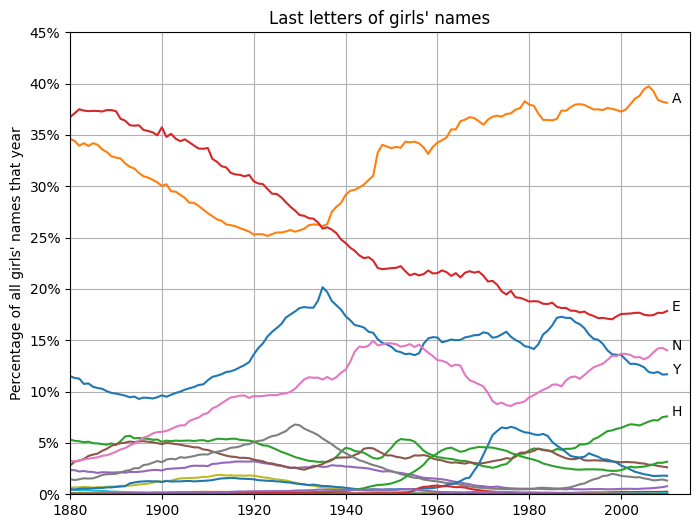

In [143]:
fig = pyplot.figure(figsize=(8, 6))
ax = fig.gca()

for suffix in suffix_total:
    suffix_count = [suffix_year[(suffix, year)] for year in YEARS]
    suffix_share = [float(sc) / t for (sc, t) in zip(suffix_count, year_total)]
    ax.plot(YEARS, suffix_share)
    if suffix_share[-1] > 0.05:
        ax.text(2011, suffix_share[-1], suffix)

ax.set_ylim(0, 0.45)
ax.set_xlim(1880, 2015)
ax.grid()

yticks_orig = ax.get_yticks()
yticks_fancy = [f'{int(100 * yt)}%' for yt in yticks_orig]
ax.set_yticks(yticks_orig, labels=yticks_fancy)

ax.set_title("Last letters of girls' names")
ax.set_ylabel("Percentage of all girls' names that year")

## Exercise 2.9

> Graphing parallel time series: The mortality data in Section 2.4 are accessible from this site at
> the U.S. Centers for Disease Control and Prevention: wonder.cdc.gov. Download mortality data
> from this source but choose just one particular cause of death, and then make graphs similar to
> those in Section 2.4, breaking down trends in death rate by age, sex, and region of the country.

I chose emphysema, and downloaded three separate datasets of "compressed mortality", for the years
1968-1978; 1979-1998; and 1999-2016.

In [144]:
class Region(enum.Enum):
    NORTHEAST = 'Northeast'
    SOUTH = 'South'
    MIDWEST = 'Midwest'
    WEST = 'West'

    @staticmethod
    def parse(region_code: str) -> 'Region':
        lookup = {
            'CENS-R1': Region.NORTHEAST,
            'CENS-R2': Region.MIDWEST,
            'CENS-R3': Region.SOUTH,
            'CENS-R4': Region.WEST
        }
        if region_code not in lookup:
            raise ValueError(f'Unrecognized region code {region_code}')
        return lookup[region_code]    

In [145]:
class AgeGroup(enum.Enum):
    AGE_UNDER_35 = '<35'
    AGE_35_44 = '35-44'
    AGE_45_54 = '45-54'
    AGE_55_64 = '55-64'
    AGE_65_74 = '65-74'
    AGE_75_84 = '75-84'
    AGE_ABOVE_84 = '85+'

    @staticmethod
    def parse(age_group_code: str) -> AgeGroup | None:
        if age_group_code == 'NS':
            return None
        unders = set(('1', '1-4', '5-9', '10-14', '15-19', '20-24', '25-34'))
        if age_group_code in unders:
            return AgeGroup.AGE_UNDER_35
        lookup = {
            '35-44': AgeGroup.AGE_35_44,
            '45-54': AgeGroup.AGE_45_54,
            '55-64': AgeGroup.AGE_55_64,
            '65-74': AgeGroup.AGE_65_74,
            '75-84': AgeGroup.AGE_75_84,
            '85+': AgeGroup.AGE_ABOVE_84,
        }
        if age_group_code not in lookup:
            raise ValueError(f'Unrecognized age group code {age_group_code}')
        return lookup[age_group_code]

In [146]:
@dataclasses.dataclass(frozen=True)
class EmphysemaMortality:
    year: int
    age_group: AgeGroup
    region: Region
    sex: str
    deaths: int
    population: int

    def add(self, other: EmphysemaMortality) -> EmphysemaMortality:
        if self.year != other.year:
            raise ValueError(f'Mismatched years: {self.year} vs. {other.year}')
        combo_age = None if self.age_group != other.age_group else self.age_group
        combo_region = None if self.region != other.region else self.region
        combo_sex = None if self.sex != other.sex else self.sex
        return EmphysemaMortality(
            year=self.year,
            age_group=combo_age,
            region=combo_region,
            sex=combo_sex,
            deaths=(self.deaths + other.deaths),
            population=(self.population + other.population),
        )

    @property
    def mortality_rate(self) -> float:
        return float(100_000 * self.deaths) / self.population

    @staticmethod
    def parse(row: dict[str, str], region_column_name: str) -> EmphysemaMortality | None:
        if row['Notes']:
            return None
        if not row['Year']:
            return None
        year = int(row['Year'])
        if not row['Age Group Code']:
            return None
        age = AgeGroup.parse(row['Age Group Code'])
        if not age:
            return None
        if not row[region_column_name]:
            return None
        region = Region.parse(row[region_column_name])
        return EmphysemaMortality(
            year=year,
            age_group=age,
            region=region,
            sex=row['Sex Code'],
            deaths=int(row['Deaths']),
            population=int(row['Population']),
        )
        

In [147]:
records = []
with open('/home/bgawalt/ros/datasets/wonder_cdc/emphysema_1968_1978.csv') as infile:
    records.extend(EmphysemaMortality.parse(row, 'Region Code') for row in csv.DictReader(infile))
with open('/home/bgawalt/ros/datasets/wonder_cdc/emphysema_1979_1998.csv') as infile:
    records.extend(EmphysemaMortality.parse(row, 'Region Code') for row in csv.DictReader(infile))
with open('/home/bgawalt/ros/datasets/wonder_cdc/emphysema_1999_2016.csv') as infile:
    records.extend(EmphysemaMortality.parse(row, 'Census Region Code') for row in csv.DictReader(infile))

records = [r for r in records if r is not None]
years = list(sorted(set(record.year for record in records)))

Text(0.5, 1.0, 'US Emphysema Mortality')

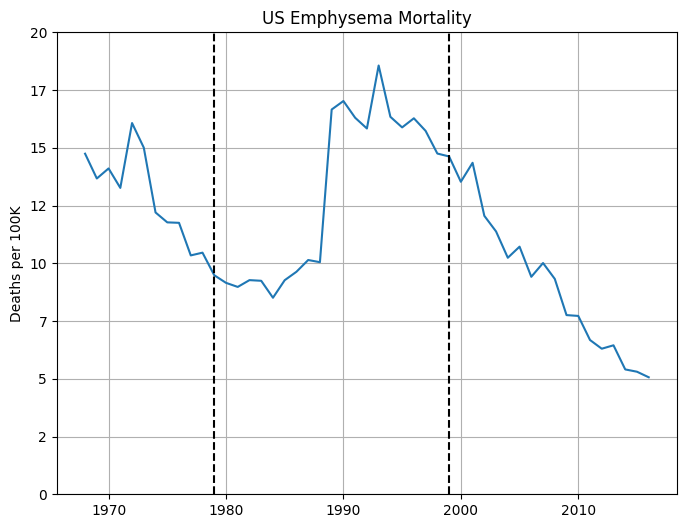

In [148]:
year_combo = {}
for record in records:
    if record.year not in year_combo:
        year_combo[record.year] = record
        continue
    combo = year_combo[record.year].add(record)
    year_combo[record.year] = combo

fig = pyplot.figure(figsize=(8,6))
ax = fig.gca()
ax.plot(years, [year_combo[year].mortality_rate for year in years])
ax.plot([1979, 1979], [0, 20], 'k--')
ax.plot([1999, 1999], [0, 20], 'k--')
ax.grid()
ax.set_ylim(0, 20)

yticks_orig = ax.get_yticks()
yticks_fancy = [f'{int(yt)}' for yt in yticks_orig]
ax.set_yticks(yticks_orig, labels=yticks_fancy)
ax.set_ylabel('Deaths per 100K')
ax.set_title('US Emphysema Mortality')

Text(0.5, 1.0, 'US Emphysema Mortality by Sex')

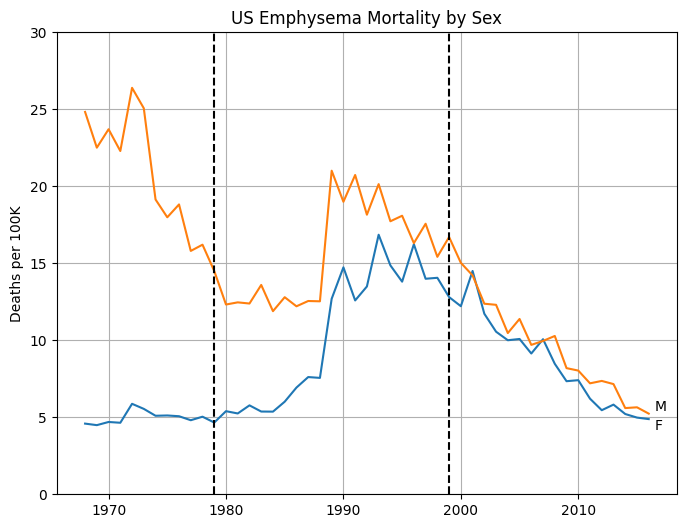

In [149]:
year_sex_combo = {}
for record in records:
    key = (record.year, record.sex)
    if key not in year_sex_combo:
        year_sex_combo[key] = record
        continue
    combo = year_sex_combo[key].add(record)
    year_sex_combo[key] = combo

fig = pyplot.figure(figsize=(8,6))
ax = fig.gca()
female_rate = [year_sex_combo[(year, 'F')].mortality_rate for year in years]
male_rate = [year_sex_combo[(year, 'M')].mortality_rate for year in years]
ax.plot(years, female_rate)
ax.text(2016.5, female_rate[-1], 'F', va='top')
ax.plot(years, male_rate)
ax.text(2016.5, male_rate[-1], 'M', va='bottom')
ax.plot([1979, 1979], [0, 30], 'k--')
ax.plot([1999, 1999], [0, 30], 'k--')
ax.grid()
ax.set_ylim(0, 30)

yticks_orig = ax.get_yticks()
yticks_fancy = [f'{int(yt)}' for yt in yticks_orig]
ax.set_yticks(yticks_orig, labels=yticks_fancy)
ax.set_ylabel('Deaths per 100K')
ax.set_title('US Emphysema Mortality by Sex')

Text(0.5, 1.0, 'US Emphysema Mortality by Age')

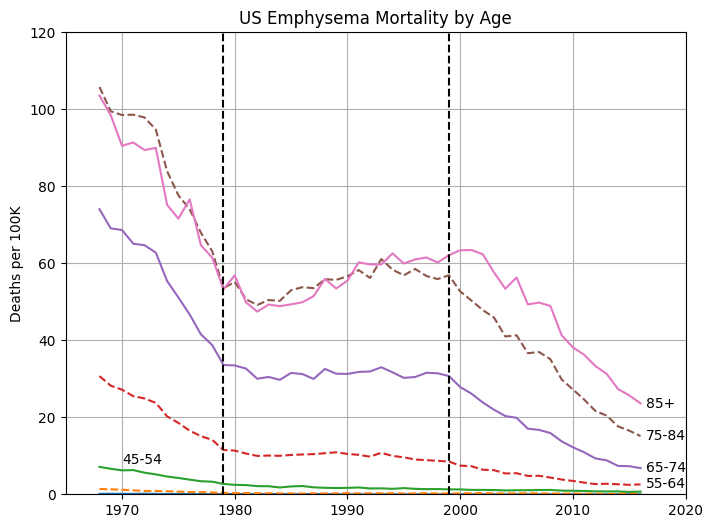

In [150]:
year_age_combo = {}
for record in records:
    key = (record.year, record.age_group)
    if key not in year_age_combo:
        year_age_combo[key] = record
        continue
    combo = year_age_combo[key].add(record)
    year_age_combo[key] = combo

fig = pyplot.figure(figsize=(8,6))
ax = fig.gca()

for age_idx, age in enumerate(AgeGroup):
    linestyle = '-' if age_idx % 2 == 0 else '--'
    rates = []
    for year in years:
        if (year, age) not in year_age_combo:
            rates.append(0)
        else:
            rates.append(year_age_combo[(year, age)].mortality_rate)
    ax.plot(years, rates, linestyle=linestyle)
    if rates[0] > 20:
        ax.text(2016.5, rates[-1], age.value, va='center')

ax.text(1970, 7, AgeGroup.AGE_45_54.value, va='bottom')
ax.plot([1979, 1979], [0, 120], 'k--')
ax.plot([1999, 1999], [0, 120], 'k--')
ax.grid()
ax.set_ylim(0, 120)
ax.set_xlim(1965, 2020)

yticks_orig = ax.get_yticks()
yticks_fancy = [f'{int(yt)}' for yt in yticks_orig]
ax.set_yticks(yticks_orig, labels=yticks_fancy)
ax.set_ylabel('Deaths per 100K')
ax.set_title('US Emphysema Mortality by Age')

Text(0.5, 0.98, 'Emphysema Mortality by Age and Region')

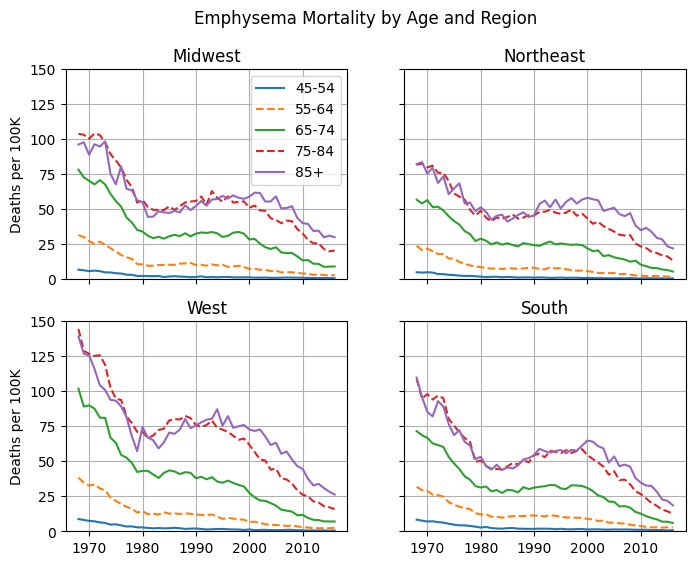

In [169]:
fig, axs = pyplot.subplots(2, 2, sharex=True, sharey=True, figsize=(8,6))
ax_midwest = axs[0, 0]
ax_midwest.set_title(Region.MIDWEST.value)
ax_midwest.set_ylabel('Deaths per 100K')
ax_north = axs[0, 1]
ax_north.set_title(Region.NORTHEAST.value)
ax_west = axs[1, 0]
ax_west.set_title(Region.WEST.value)
ax_west.set_ylabel('Deaths per 100K')
ax_south = axs[1, 1]
ax_south.set_title(Region.SOUTH.value)

def regional_age_mortality(ax, region):
    year_age_combo = {}
    for record in records:
        if record.region != region:
            continue
        key = (record.year, record.age_group)
        if key not in year_age_combo:
            year_age_combo[key] = record
            continue
        combo = year_age_combo[key].add(record)
        year_age_combo[key] = combo
    
    for age_idx, age in enumerate(AgeGroup):
        if age in set([AgeGroup.AGE_UNDER_35, AgeGroup.AGE_35_44]):
            continue
        linestyle = '-' if age_idx % 2 == 0 else '--'
        rates = []
        for year in years:
            if (year, age) not in year_age_combo:
                rates.append(0)
            else:
                rates.append(year_age_combo[(year, age)].mortality_rate)
        ax.plot(years, rates, linestyle=linestyle, label=age.value)
    ax.set_ylim(0, 150)
    if region == Region.MIDWEST:
        ax.legend()
    
    yticks_orig = ax.get_yticks()
    yticks_fancy = [f'{int(yt)}' for yt in yticks_orig]
    ax.set_yticks(yticks_orig, labels=yticks_fancy)
    ax.grid()

regional_age_mortality(ax_midwest, Region.MIDWEST)
regional_age_mortality(ax_north, Region.NORTHEAST)
regional_age_mortality(ax_south, Region.SOUTH)
regional_age_mortality(ax_west, Region.WEST)
fig.suptitle('Emphysema Mortality by Age and Region')